<a href="https://colab.research.google.com/github/RemyLpr/defi_ia/blob/main/feature_engineering/golden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce notebook on va créer un dataframe contenant les prix pour chaque hôtel à chaque date avec les autres paramètres fixés (mobile = 0, langue = hongrois). Pour les valeurs manquantes on va les inférer à l'aide d'autres hôtels dont l'évolution des stocks est semblable.

# Import des librairies et des données

In [10]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import normalize
from scipy.spatial import distance
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [89]:
df_stock = pd.read_csv("stock.csv")
df_vienna = pd.read_csv("vienna.csv")
df_vilnius = pd.read_csv("vilnius.csv")
df_amsterdam = pd.read_csv("amsterdam.csv")
df_rome = pd.read_csv("rome.csv")
df_valletta = pd.read_csv("valletta.csv")
df_paris = pd.read_csv("paris.csv")
df_madrid = pd.read_csv("madrid.csv")
df_copenhagen = pd.read_csv("copenhagen.csv")
df_sofia = pd.read_csv("sofia.csv")
df = pd.concat([df_vienna, df_vilnius, df_amsterdam, df_rome, df_valletta, df_paris, df_madrid, df_copenhagen, df_sofia])

# Création de la feature Vente à partir des stocks

Pour chaque hôtel et chaque jour on va calculer combien de chambres ont été vendues.

In [90]:
newrow_list = []
for index, row in df_stock.iterrows():
  newrow = []
  for col in df_stock.columns:
    col = int(col)
    if col < 44:
      newrow.append(row[col+1] - row[col])
    else:
      newrow[-1] = 0
  newrow_list.append(newrow)
df_vente = pd.DataFrame(data = newrow_list)

# Séparation des données et association au meilleur voisin

On va ici séparer les données entre les hôtels non-requêtables sur certains jours et donc ayant des prix manquants et les hôtels dont on a les prix pour tous les jours. Nous allons utiliser les seconds pour inférer des valeurs de prix pour les premiers. Pour cela on va sélectionner le meilleur voisin d'un hôtel contenant des données manquantes à partir de l'évolution de ses stocks, potentiellement complétée préalablement dans le notebook stock.

In [91]:
price_list = [] # liste de liste des prix pour chaque jour pour chaque hôtel
for hotel in range(0, 999):
  df_hot = df[df["hotel_id"] == hotel]
  price_per_hotel = [] # liste des prix pour chaque jour pour un hôtel
  for date in range(0, 45):
    df_hot_date = df_hot[df_hot["date"] == date]
    price = df_hot_date["price"].mean()
    price_per_hotel.append(price)
  price_list.append(price_per_hotel)

In [92]:
df_price = pd.DataFrame(data = price_list) 
df_na = df_price[df_price.isna().any(axis=1)] # hôtels ayant des données manquantes
df_no_na = df_price.dropna() # hôtels sans données manquantes

Maintenant que l'on a la liste des hôtels contenants des données manquantes on va leur associer leur meilleur voisin et inférer les valeurs absentes.

In [97]:
for index, row in df_na.iterrows(): # on parcourt les hôtels ayants des prix manquants
  list_dist = [] # liste des distances entre l'hôtel A et ses voisins
  list_na = [] # liste des valeurs manquantes pour l'hôtel A
  list_row = [] # liste des lignes correspondants aux hôtels testés en tant que voisins
  newrow = [] # ligne correspondant à l'hôtel A que l'on va remplir avec les prix inférés
  hotel_A = index
  vente_A = df_vente[df_vente.index == hotel_A] # on récupère les stocks pour l'hôtel A
  for col in range(len(row)):
    rowcopy = row.copy()
    if math.isnan(row[col]):
      list_na.append(col) 
  normalized_vente_A = normalize([vente_A.values[0]])
  for index2, row2 in df_no_na.iterrows(): # on parcourt les hôtels dont a le prix pour tous les jours
    hotel_B = index2
    vente_B = df_vente[df_vente.index == hotel_B] # stocks de l'hôtel B
    normalized_vente_B = normalize([vente_B.values[0]])
    dist = distance.euclidean(normalized_vente_A[0][list_na], normalized_vente_B[0][list_na]) # calcul de distance entre les 2 évolutions de stocks normalisées
    list_dist.append(dist)
    list_row.append(row2)
  indice_min = np.argmin(list_dist)
  voisin = df_no_na.iloc[indice_min]
  rowv = list_row[indice_min]

  # pour afficher les paires hotel de df_na et son + proche voisin
  #print(index, voisin.name)

  # calcul du coeff entre les prix des 2 hôtels voisins
  first, last = list_na[0], list_na[-1]
  if first!=0:
    bg_A, bg_B = row[first-1], list_row[indice_min][first-1]
    part_1 = (row[:first] / rowv[:first]).tolist()
    part_2 = (row[last+1:] / rowv[last+1:]).tolist()
    all = part_1 + part_2
    coeff = np.mean(all)
  else:
    bg_A, bg_B = 0, 0
    coeff = np.mean((row[last+1:] / rowv[last+1:]).tolist())
  bd_A, bd_B = row[last+1], list_row[indice_min][last+1]

  # remplissage des trous dans les prix
  for j in range(len(rowcopy)):
    if j in list_na:
      if bg_B == bd_B: # cas borne gauche = borne droite, on remplit par cette valeur
        newrow.append(bg_A)
      else:
        estimation = round(voisin[j]*coeff)
        if (estimation > bg_A) & (bg_A !=0): # cas estimation > borne gauche, absurde car le prix décroît avec la variable date
          newrow.append(bg_A)
        elif estimation < bd_A: # cas estimation < borne droite, absurde pour la même raison
          newrow.append(bd_A)
        else:
          newrow.append(round(voisin[j]*coeff))
    else:
      newrow.append(rowcopy[j])
  df_na.at[index] = newrow

# Visualisation des résultats

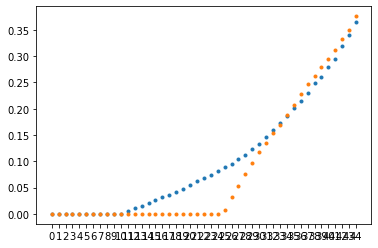

In [44]:
# évolution des stocks
df_a = df_stock[df_stock.index == 10]
df_b = df_stock[df_stock.index == 776]
df_a = normalize([df_a.values.tolist()[0]])
df_b = normalize([df_b.values.tolist()[0]])
plt.plot(df_stock.columns.tolist(), df_a[0], '.')
plt.plot(df_stock.columns.tolist(), df_b[0], '.')

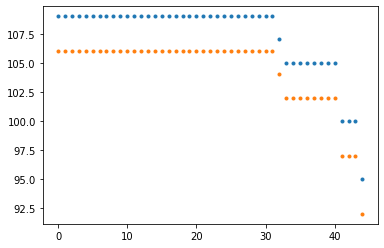

In [86]:
# sans données ajoutées
df_a = df[df["hotel_id"] == 59]
df_b = df[df["hotel_id"] == 82]
plt.plot(df_a["date"], df_a["price"], '.')
plt.plot(df_b["date"], df_b["price"], '.')

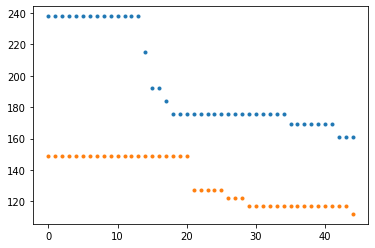

In [ ]:
# avec données ajoutées
df_a = df_na.loc[[0]]
df_b = df[df["hotel_id"] == 47]
plt.plot(df_b["date"], df_a.values[0], '.')
plt.plot(df_b["date"], df_b["price"], '.')

# Export de la nouvelle feature

In [98]:
df_golden = pd.concat([df_na, df_no_na])
df_golden = df_golden.sort_index()
df_golden.to_csv("golden_vente_local.csv", index = False)